In [ ]:
#!pip install --upgrade pip
#!pip install --upgrade setuptools
#!pip install --upgrade torch torchvision torchaudio
#!pip install --upgrade torchtext

In [25]:
import torch
print(torch.__version__)

2.0.0+cu118


In [26]:
import nltk   
import spacy            
import re     
import string            
import numpy as np
import pandas as pd
import random
import collections
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples    # Corpus Twitter
from nltk.tokenize import word_tokenize 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchtext
from collections import Counter
from torchtext.vocab import vocab
from torch.utils.data.sampler import Sampler
import torch.nn as nn
import time
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In [28]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [29]:
pos_tweets = twitter_samples.strings('positive_tweets.json') #tweets positivos
neg_tweets = twitter_samples.strings('negative_tweets.json') #tweets negativos

print("Positive tweets: ", len(pos_tweets))
print("Negative tweets: ", len(neg_tweets))

Positive tweets:  5000
Negative tweets:  5000


In [63]:
def custom_tokenizer(nlp):
    special_cases = {":)": [{"ORTH": ":)"}], ":(": [{"ORTH": ":("}],":-(": [{"ORTH": ":-("}]}
    simple_url_re = re.compile(r'''^https?://''')
    suffixes = nlp.Defaults.suffixes + [r'''-+$''',]
    suffix_regex = spacy.util.compile_suffix_regex(suffixes)
    return spacy.tokenizer.Tokenizer(nlp.vocab, rules=special_cases, suffix_search=suffix_regex.search, url_match=simple_url_re.match)

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = custom_tokenizer(nlp)

In [64]:
def normalization(data, regularization="lemma", language='english'):
  stopwords = nltk.corpus.stopwords.words(language)
  ps = PorterStemmer()
  normalized_data = []
  
  for tweet in data:
    tweet = re.sub(r'^RT[\s]+', '', tweet) # identificar retweets
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet) #eliminar links
    tweet = re.sub(r'#', '', tweet) #eliminar símbolo gato
    tweet = re.sub(r'@\w+', '', tweet) #eliminar palabras que inicias con @
    tweet = re.sub(r'\d+', '', tweet) #eliminar números
    tweet = re.sub(' +', ' ', tweet) #quitar espacios

    if regularization == "stem":
      tweetTokenizer = TweetTokenizer()
      words = tweetTokenizer.tokenize(tweet)
      tokens = [ps.stem(w) for w in words]
    if regularization == "lemma":
      doc = nlp(tweet)
      tokens = [token.lemma_ for token in doc]
    else:
      doc = nlp(tweet)
      tokens = [token.text for token in doc]
    
    normalized_tweets = [w.lower() for w in tokens if w.lower() not in stopwords and not w==' ' and w not in string.punctuation]
    normalized_data.append(normalized_tweets)
  return normalized_data

In [65]:
norm_pos = normalization(pos_tweets)
norm_neg = normalization(neg_tweets)

In [66]:
labels_pos = [1]*len(norm_pos)
labels_neg = [0]*len(norm_neg)
X = norm_pos + norm_neg
y = labels_pos + labels_neg
X_txt = pos_tweets + neg_tweets

In [67]:
SPLIT_TEST = 0.2
SUB_SPLIT_TEST = 0.98

In [68]:
X_train, X_test_eval, y_train, y_test_eval = train_test_split(X, y, test_size=SPLIT_TEST, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_eval, y_test_eval, test_size=SUB_SPLIT_TEST, random_state=42)

In [69]:
_, X_txt_test_eval, _, y_txt_test_eval = train_test_split(X_txt, y, test_size=SPLIT_TEST, random_state=42)
X_txt_test, _, _, _ = train_test_split(X_txt_test_eval, y_txt_test_eval, test_size=SUB_SPLIT_TEST, random_state=42)

In [70]:
print("Train set size: ", len(X_train))
print("Evaluation set size: ",len(X_val))
print("Test set size: ",len(X_test))

Train set size:  8000
Evaluation set size:  1960
Test set size:  40


In [71]:
counter_train = Counter([word for sentence in X_train for word in sentence])

In [72]:
#con vocab convertimos palabras a índices
voc = vocab(counter_train, min_freq = 3, specials=('<pad>','<unk>'))
voc.set_default_index(voc['<unk>'])
print("La cantidad de tokens en el vocabulario es:", len(voc))
s = ':)'
print(f"El índice del token '{s}' es {voc[s]}")
itos = voc.get_itos()
i = 2
print(f"El token con indice {i} es {itos[i]}")
s = "AYAYA"
print(f"A la palabra '{s}' le corresponde el token {itos[voc[s]]}")
print(voc.get_itos()[:10])

La cantidad de tokens en el vocabulario es: 2215
El índice del token ':)' es 7
El token con indice 2 es :(
A la palabra 'AYAYA' le corresponde el token <unk>
['<pad>', '<unk>', ':(', 'matt', 'good', 'thank', 'anyway', ':)', 'bf', 'mean']


In [73]:
train_tuple_list = [(y_train[i],x) for i, x in enumerate(X_train)]
val_tuple_list = [(y_val[i], x) for i, x in enumerate(X_val)]
test_tuple_list = [(y_test[i], x) for i, x in enumerate(X_test)]

Armado de dataloaders


In [74]:
SEED = 10
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
class BucketSampler(Sampler):

    def __init__(self, batch_size, train_list):
        self.length = len(train_list)
        self.train_list = train_list
        self.batch_size = batch_size
        indices = [(i, len(s[1])) for i, s in enumerate(self.train_list)]
        random.seed(SEED)
        random.shuffle(indices)
        pooled_indices = []
        # creamos minilotes de tamaños similares
        for i in range(0, len(indices), self.batch_size * 100):
            pooled_indices.extend(sorted(indices[i:i + self.batch_size * 100], key=lambda x: x[1], reverse=True))

        self.pooled_indices = pooled_indices

    def __iter__(self):
        for i in range(0, len(self.pooled_indices), self.batch_size):
            yield [idx for idx, _ in self.pooled_indices[i:i + self.batch_size]]

    def __len__(self):
        return self.length
        return (self.length + self.batch_size - 1) // self.batch_size

In [75]:
#Función que le dice al dataloader como cargar los datos
#Rellena una lista de tensores de longitud variable
#Apila una lista de tensores a lo largo de una nueva dimensión y los rellena para que tengan la misma longitud
from torch.nn.utils.rnn import pad_sequence 
PADDING_IDX = voc['<pad>']

def collate_batch(batch):
    text_list, label_list, length_list = [], [], []
    for (_label, _text_tokens) in batch:
        label_list.append(_label)
        processed_text = torch.tensor([voc[token] for token in _text_tokens])
        text_list.append(processed_text)
        length_list.append(len(processed_text))
        # armamos la tupla que conformara un ejemplo de minilote.
    result = (torch.tensor(label_list),
              pad_sequence(text_list, padding_value=PADDING_IDX),
              torch.tensor(length_list) )
    return result

In [76]:
from torch.utils.data import DataLoader
batch_size = 64  # A batch size of 64
#entrenamiento
train_batch = BucketSampler(batch_size, train_tuple_list)
train_iterator = DataLoader(train_tuple_list, batch_sampler=train_batch, collate_fn=collate_batch)
#validación
val_batch = BucketSampler(batch_size, val_tuple_list)
val_iterator = DataLoader(val_tuple_list, batch_sampler=val_batch, collate_fn=collate_batch)
#test
test_batch = BucketSampler(batch_size, test_tuple_list)
test_iterator = DataLoader(test_tuple_list, batch_sampler=test_batch, collate_fn=collate_batch)

print("Tamaño de DataLoader de entrenamiento: ", len(train_iterator))
print("Tamaño de DataLoader de validación: ", len(val_iterator))
print("Tamaño de DataLoader de test", len(test_iterator))

Tamaño de DataLoader de entrenamiento:  8000
Tamaño de DataLoader de validación:  1960
Tamaño de DataLoader de test 40


In [77]:
sr = next(iter(train_iterator))
sr[1].shape

torch.Size([52, 64])

BI-LSTM

In [78]:
class BILSTM(nn.Module):
    #vocab_size:Es la dimensión de entrada de nuestra red (dimensión de los vectores one-hot). Es decir, es el tamaño del vocabulario.
    #embedding_dim: La dimensión a la salida de Embedding es el tamaño de los vectores de palabras densas. Suele tener entre 50 y 250 
    #dimensiones, pero depende del tamaño del vocabulario.
    #hidden_dim: La dimensión del estado oculto es el tamaño de las variables ocultas. Suele rondar entre 100 y 500 dimensiones, 
    #pero también depende de factores como el tamaño del vocabulario, el tamaño de los vectores densos y la complejidad de la tarea.
    #output_dim: La dimensión de salida suele ser el número de clases, sin embargo, en el caso de solo 2 clases, el valor de salida está 
    #entre 0 y 1 y, por lo tanto, puede ser unidimensional, es decir, un solo número real escalar.
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
      self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
      self.fc = nn.Linear(hidden_dim * 2, output_dim)
      self.dropout = nn.Dropout(dropout)
 
        
    def forward(self, text):
      #text = [sent len, batch size]
      embedded = self.dropout(self.embedding(text))
      #embedded = [sent len, batch size, emb dim]

      output, (hidden, cell) = self.rnn(embedded)
        
      #hidden = [num layers * num directions, batch size, hid dim]
      #cell = [num layers * num directions, batch size, hid dim]
        
      #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
      #and apply dropout
        
      hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
      #hidden = [batch size, hid dim * num directions]
            
      return self.fc(hidden)

In [79]:
INPUT_DIM = len(voc)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = voc.get_stoi()['<pad>']

model1 = BILSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [80]:
def count_parameters(model):
    return sum(p.numel() for p in model1.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model1):,} trainable parameters')

The model has 955,197 trainable parameters


In [81]:
import torch.optim as optim
LEARNING_RATE = 0.00015
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
model1 = model1.to(device)
criterion = criterion.to(device)

Entrenamiento

In [82]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # aproximamos al entera más cercano
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convertimos a flotante para la división
    acc = correct.sum() / len(correct)
    return acc

In [83]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [84]:
def train_loop(model,iterator,optimizer,criterion,device=device,clip = 1.0):
    #Training loop
    model.train()
    loss_sum = 0
    acc_sum = 0
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    y_true = []
    y_pred = []

    for i, (label, text, _) in enumerate(iterator):
        
        label = label.float().to(device)
        text = text.to(device)

        optimizer.zero_grad()
        #Forward 
        outputs = model(text).squeeze(1)
        #Loss
        loss = criterion(outputs, label)
        #ACC
        acc = binary_accuracy(outputs, label)
        #Backprop
        loss.backward()
        #prevent gradients from exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        #Update params
        optimizer.step()

        loss_sum += loss.item()
        acc_sum += acc.item()

        y_true.extend(label.tolist())
        y_pred.extend(torch.round(torch.sigmoid(outputs)).tolist())

    epoch_train_loss = loss_sum * batch_size / len(iterator)
    epoch_train_acc = acc_sum * batch_size / len(iterator)


    return epoch_train_loss,  epoch_train_acc, y_true, y_pred


In [85]:
def evaluation_loop(model,iterator,criterion,device=device):
    #Evaluation loop
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        loss_sum = 0
        acc_sum = 0

        for i, (label, text, _) in enumerate(iterator):

            label = label.float().to(device)
            text = text.to(device)

            #Forward
            outputs = model(text).squeeze(1)
            #Loss
            loss = criterion(outputs, label)
            #ACC
            acc = binary_accuracy(outputs, label)

            loss_sum += loss.item()
            acc_sum += acc.item()
        
            y_true.extend(label.tolist())
            y_pred.extend(torch.round(torch.sigmoid(outputs)).tolist())
        
        epoch_dev_loss = loss_sum * batch_size / len(iterator)
        epoch_dev_acc = acc_sum * batch_size / len(iterator)

    return epoch_dev_loss, epoch_dev_acc, y_true, y_pred

In [86]:
NUM_EPOCHS = 4
best_valid_loss = float('inf')
model_name = 'Vanilla_RNN_model'
train_loss_values, eval_loss_values = [], []
target_names = ['Negative', 'Positive']
history = {"train": {"loss": [], "acc": []}, "test": {"loss": [], "acc": []}}

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

for epoch in range(NUM_EPOCHS):
    
    start_time = time.time()

    epoch_train_loss, epoch_train_acc, y_train_true, y_train_pred = train_loop(model1,train_iterator,optimizer1,criterion,device)
    epoch_dev_loss, epoch_dev_acc, y_dev_true, y_dev_pred = evaluation_loop(model1,val_iterator,criterion,device)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_loss_values.append(epoch_train_loss)
    eval_loss_values.append(epoch_dev_loss)

    #nos quedamos con el modelo que tiene mejor pérdida de validación
    if epoch_dev_loss < best_valid_loss:
      best_valid_loss = epoch_dev_loss
      torch.save(model1.state_dict(), model_name +'.pt')
    

    history["train"]["loss"].append(epoch_train_loss)
    history["train"]["acc"].append(epoch_train_acc)
    history["test"]["loss"].append(epoch_dev_loss)
    history["test"]["acc"].append(epoch_dev_acc)

    print('-' * 120)
    #print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Epoch Time: {epoch_mins}m {epoch_secs}s | Train loss: {epoch_train_loss:.4f} | Train acc: {epoch_train_acc:.4f} | Dev loss: {epoch_dev_loss:.4f} | Dev acc: {epoch_dev_acc:.4f}')
    print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Epoch Time: {epoch_mins}m {epoch_secs}s | Train loss: {epoch_train_loss:.4f} | Dev loss: {epoch_dev_loss:.4f}')
    print()
    print("Entrenamiento: ")
    print(classification_report(y_train_true, y_train_pred, target_names=target_names, digits=4))
    print()
    print("Validación: ")
    print(classification_report(y_dev_true, y_dev_pred, target_names=target_names, digits=4))

------------------------------------------------------------------------------------------------------------------------
Epoch: 001/4 | Epoch Time: 0m 6s | Train loss: 0.3923 | Dev loss: 0.1409

Entrenamiento: 
              precision    recall  f1-score   support

    Negative     0.8465    0.9275    0.8851      4012
    Positive     0.9193    0.8307    0.8728      3988

    accuracy                         0.8793      8000
   macro avg     0.8829    0.8791    0.8789      8000
weighted avg     0.8827    0.8792    0.8790      8000


Validación: 
              precision    recall  f1-score   support

    Negative     0.9600    0.9630    0.9615       972
    Positive     0.9635    0.9605    0.9620       988

    accuracy                         0.9617      1960
   macro avg     0.9617    0.9617    0.9617      1960
weighted avg     0.9617    0.9617    0.9617      1960

------------------------------------------------------------------------------------------------------------------------


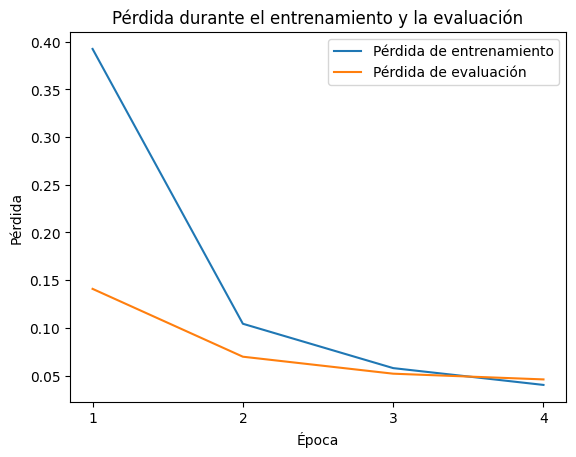

In [87]:
# Crear un objeto Figure y un objeto Axes.
fig, ax = plt.subplots()

# Desplazar los valores de iteración en el eje x y graficar las listas de pérdidas de entrenamiento y evaluación utilizando la función plot().
ax.plot([i+1 for i in range(len(train_loss_values))], train_loss_values, label='Pérdida de entrenamiento')
ax.plot([i+1 for i in range(len(eval_loss_values))], eval_loss_values, label='Pérdida de evaluación')

# Agregar etiquetas y títulos apropiados.
ax.set_xlabel('Época')
ax.set_ylabel('Pérdida')
ax.set_title('Pérdida durante el entrenamiento y la evaluación')

# Ajustar los ticks del eje x para que comience en la época 1.
ax.set_xticks([i+1 for i in range(len(train_loss_values))])

# Agregar una leyenda que explique qué línea corresponde a las pérdidas de entrenamiento y qué línea corresponde a las pérdidas de evaluación.
ax.legend()

# Mostrar la figura.
plt.show()

In [88]:
model1.load_state_dict(torch.load(model_name+'.pt', map_location=torch.device(device)))

<All keys matched successfully>

In [89]:
def test_sentiment(num_example, vocabulary, model,device=device):
    print("Example: ", X_txt_test[num_example])
    tuple_sent = test_tuple_list[num_example]
    if tuple_sent[0] == 0:
      print("Target: Negative sentiment")
    else:
      print("Target: Positive sentiment")
    norm_txt = normalization([X_txt_test[num_example]])[0]
    print("Normalization: ", norm_txt)
    text = torch.tensor([[voc[token] for token in norm_txt]]).T

    model.eval()
    with torch.no_grad():
      text = text.to(device)
      output = model(text).squeeze(1)
      o = torch.round(torch.sigmoid(output))
    #print("Output: ", output)
    if round(o.item(),3) == 0:
          print("Predicted: Negative sentiment")
    else:
          print("Predicted: Positive sentiment")

In [94]:
#21, 33, 37, 39
NUM_EXAMPLE = 37
test_sentiment(NUM_EXAMPLE,voc,model1)

Example:  @norman__g lucky spike only :-(
Target: Negative sentiment
Normalization:  ['lucky', 'spike', ':-(']
Predicted: Negative sentiment
